# Data Structures

In [28]:
# Data Structures
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import List, Tuple, Dict
import time
import re

class KnapsackInstance:
    """
    Simple data structure that stores all relevant information
    for a single knapsack instance.

    This keeps the solver code clean and ensures all instance data
    is bundled together in one object.
    """

    def __init__(self, name: str, num_items: int, 
                 num_knapsacks: int, capacities: List[int], profits: List[int], 
                 weights: np.ndarray, optimal_value: int = None):
        """
        Initialize a knapsack instance.

        Args:
            name (str): Name/identifier of the instance (e.g., WEING3, WEISH08)
            num_items (int): Number of items (n)
            num_knapsacks (int): Number of knapsack constraints (m)
            capacities (List[int]): Capacity limit for each of the m knapsacks
            profits (List[int]): Profit/value of each item
            weights (np.ndarray): Weight matrix of shape (m, n)
            optimal_value (int, optional): Known optimal value if available
        """

        self.name = name
        self.num_items = num_items
        self.num_knapsacks = num_knapsacks
        self.capacities = capacities
        self.profits = profits
        self.weights = weights
        self.optimal_value = optimal_value


## Data Loader for Knapsack Benchmark Instances


In [29]:
# Data Loading
class DataLoader:
    """
    Klasse som håndterer innlasting av knapsack-instanser fra fil.
    Jeg legger all parsing her så resten av koden slipper å bry seg
    om filformatene.
    """

    def load_or_library(self, filepath, instance_names):
        """
        Leser MKP-instanser fra OR-Library (mknap2.txt).
        Formatet er litt spesielt, så her parser jeg det manuelt.
        """
        with open(filepath, 'r') as file:
            content = file.read()

        # Fjerner kommentarer og unødvendig whitespace
        def clean_line(line: str) -> str:
            if '//' in line:
                line = line[:line.index('//')]
            return line.strip()

        instances = []
        content_lower = content.lower()

        for name in instance_names:
            # OR-Library bruker headeren "PROBLEM <navn>.DAT"
            search_pattern = f"problem {name}.dat"
            idx = content_lower.find(search_pattern.lower())

            if idx == -1:
                print(f"Warning: Instance {name} not found")
                continue

            # Går til første linje etter header
            start_pos = content.find('\n', idx) + 1

            # Hopper over tomme/++++-linjer til vi finner m og n
            while start_pos < len(content):
                line_end = content.find('\n', start_pos)
                first_line = clean_line(content[start_pos:line_end])
                if first_line and not first_line.startswith('++++'):
                    break
                start_pos = line_end + 1

            if not first_line:
                print(f"Warning: Could not find m,n for {name}")
                continue

            # Leser m og n fra første gyldige linje
            parts = first_line.split()
            if len(parts) < 2:
                print(f"Warning: Could not parse m,n for {name}")
                continue

            m = int(parts[0])
            n = int(parts[1])

            # Blokker er adskilt av "PROBLEM"
            data_start = line_end + 1
            next_idx = content_lower.find("problem ", data_start)
            data_end = next_idx if next_idx != -1 else len(content)

            instance_text = content[data_start:data_end]
            numbers = []

            # Leser alle tall i blokken (hopper over ++++/kommentarer)
            for line in instance_text.split('\n'):
                cleaned = clean_line(line)
                if not cleaned or cleaned.startswith('++++'):
                    continue
                for token in cleaned.split():
                    try:
                        numbers.append(int(token))
                    except ValueError:
                        pass

            expected_count = n + m + (m * n) + 1
            if len(numbers) < expected_count:
                print(f"Warning: Not enough numbers for {name}. Expected {expected_count}, got {len(numbers)}")
                continue

            # Siste tall er optimal verdi
            opt = numbers[-1]
            numbers = numbers[:-1]

            # Først n profits → deretter m capacities → så m*n weights
            profits = numbers[:n]
            capacities = numbers[n:n+m]

            weights = []
            weight_start = n + m
            for i in range(m):
                row_start = weight_start + i * n
                weights.append(numbers[row_start: row_start + n])

            instances.append(
                KnapsackInstance(name, n, m, capacities, profits, np.array(weights), opt)
            )

        return instances


    def load_pisinger(self, filepath, instance_name):
        """
        Leser Pisingers "hard" knapsack-instanser (CSV-format).
        Disse har et ryddigere oppsett, så parsing er mer rett frem.
        """
        with open(filepath, 'r') as file:
            content = file.read()

        # Finner riktig blokk basert på instansnavnet
        match = re.search(rf"{instance_name}\n(.*?)(?=\nknapPI_|\Z)", content, re.DOTALL)
        if not match:
            raise ValueError(f"Instance {instance_name} not found")

        lines = match.group(1).strip().split('\n')

        n = int(lines[0].split()[1])
        capacity = int(lines[1].split()[1])
        optimal = int(lines[2].split()[1])

        # Items ligger på form: index, profit, weight
        profits, weights = [], []
        for line in lines[4:4+n]:
            parts = line.split(',')
            profits.append(int(parts[1]))
            weights.append(int(parts[2]))

        return KnapsackInstance(
            instance_name, n, 1, [capacity], profits, np.array([weights]), optimal
        )


## Greedy Baseline Heuristic for the Knapsack Problem


In [30]:
def greedy_baseline(instance):
    """
    Greedy baseline algorithm for the knapsack problem.

    Idea:
        - Compute profit-to-weight efficiency for each item
        - Sort items by efficiency (descending)
        - Add items in that order as long as all capacity constraints remain satisfied

    Args:
        instance (KnapsackInstance): Problem instance

    Returns:
        tuple:
            solution (np.ndarray): Binary vector representing chosen items
            value (float): Total profit of the greedy solution
    """

    # Compute average weight per item across all knapsacks
    # (used as a single combined weight metric for sorting)
    avg_weights = np.mean(instance.weights, axis=0)

    # Efficiency = profit / weight
    efficiencies = instance.profits / (avg_weights + 1e-6)

    # Items sorted from highest efficiency → lowest
    sorted_items = np.argsort(efficiencies)[::-1]

    # Start with an empty solution
    solution = np.zeros(instance.num_items, dtype=int)

    # Greedily add items if they keep the solution feasible
    for item in sorted_items:
        solution[item] = 1  # try including the item

        # Check feasibility for every knapsack
        feasible = True
        for k in range(instance.num_knapsacks):
            total_weight = np.dot(solution, instance.weights[k])
            if total_weight > instance.capacities[k]:
                feasible = False
                break

        # Undo if infeasible
        if not feasible:
            solution[item] = 0

    # Compute total profit
    value = np.dot(solution, instance.profits)

    return solution, value


## Bees Algorithm (Standard Version) for the 0–1 Multi-Knapsack Problem


In [31]:
# BA Standard
class BeesAlgorithmStandard:
    """ 
    Standard Bees Algorithm for the 0-1 (multi-)knapsack problem.

    I follow the classical BA structure:
    - Scout bees: explore new regions randomly
    - Elite and selected sites: local search around good solutions
    - Neighborhood shrinking: gradually move from exploration → exploitation
    - Abandonment: replace stagnant sites that stop improving
    """

    def __init__(self, instance, num_scout_bees=50, num_selected_sites=10,
                 num_elite_sites=5, num_bees_elite=20, num_bees_selected=10,
                 max_iterations=100, initial_neighborhood_size=5,
                 shrinking_factor=0.8, stagnation_limit=10, random_seed=None):
        """
        Set up the Bees Algorithm with the parameters I want to experiment with.

        In general:
        - num_scout_bees controls population size
        - num_selected_sites / num_elite_sites control how many good sites we exploit
        - shrinking_factor decides how fast the neighborhood radius shrinks
        - stagnation_limit controls when a site is considered "dead" and replaced
        """

        # Basic parameter checks
        if num_elite_sites > num_selected_sites:
            raise ValueError("num_elite_sites must be <= num_selected_sites")
        if num_selected_sites > num_scout_bees:
            raise ValueError("num_selected_sites must be <= num_scout_bees")
        if not (0 < shrinking_factor <= 1):
            raise ValueError("shrinking_factor must be in (0, 1]")
        if stagnation_limit < 1:
            raise ValueError("stagnation_limit must be >= 1")

        # Core BA parameters
        self.instance = instance
        self.num_scout_bees = num_scout_bees
        self.num_selected_sites = num_selected_sites
        self.num_elite_sites = num_elite_sites
        self.num_bees_elite = num_bees_elite
        self.num_bees_selected = num_bees_selected
        self.max_iterations = max_iterations

        # Neighborhood shrinking
        self.initial_neighborhood_size = initial_neighborhood_size
        self.shrinking_factor = shrinking_factor
        self.current_neighborhood_size = float(initial_neighborhood_size)

        # Site abandonment
        self.stagnation_limit = stagnation_limit
        self.stagnation_counter = np.zeros(num_selected_sites, dtype=np.int32)

        # Seed for reproducibility
        if random_seed is not None:
            np.random.seed(random_seed)

        # Tracking
        self.best_solution = None
        self.best_value = -np.inf
        self.best_iteration = 0
        self.convergence_history = []
        self.iteration_times = []

        # Large penalty for infeasible solutions
        self.penalty = 1e10

    # ---------------------------------------------------------------
    # FITNESS
    # ---------------------------------------------------------------
    def evaluate_fitness(self, solution):
        """
        Fitness = profit if solution is feasible.
        If infeasible → large negative penalty based on total capacity violation.
        """
        if not self.is_feasible(solution):
            violations = np.maximum(
                0, np.dot(solution, self.instance.weights.T) - self.instance.capacities
            )
            return -self.penalty * np.sum(violations)

        return np.dot(solution, self.instance.profits)

    def is_feasible(self, solution):
        """
        Check if the solution respects all capacity constraints.
        """
        weights_used = np.dot(solution, self.instance.weights.T)
        return np.all(weights_used <= self.instance.capacities)

    # ---------------------------------------------------------------
    # REPAIR
    # ---------------------------------------------------------------
    def repair_solution(self, solution):
        """
        Repair an infeasible solution by iteratively removing items.

        Idea:
        - Identify overloaded knapsacks
        - Remove items that are "bad" (high weight, low profit)
        - Continue until the solution becomes feasible or empty
        """
        solution = solution.copy()
        profits_array = np.asarray(self.instance.profits)

        max_iters = self.instance.num_items
        it = 0

        while not self.is_feasible(solution) and it < max_iters:
            it += 1

            selected = np.flatnonzero(solution)
            if selected.size == 0:
                break

            # Compute overload per knapsack
            weight_used = np.dot(solution, self.instance.weights.T)
            violations = np.maximum(0, weight_used - self.instance.capacities)

            worst_knapsack = np.argmax(violations)
            if violations[worst_knapsack] == 0:
                break

            # Weights and profits of selected items in the worst knapsack
            w = self.instance.weights[worst_knapsack, selected]
            p = profits_array[selected]

            # High w / low p → high removal score
            removal_scores = w / (p + 1e-6)
            remove_idx = selected[np.argmax(removal_scores)]

            solution[remove_idx] = 0

        return solution

    # ---------------------------------------------------------------
    # LOCAL SEARCH
    # ---------------------------------------------------------------
    def local_search(self, solution, num_neighbors):
        """
        Explore neighbor solutions by flipping a subset of bits.
        The neighborhood size shrinks during the search.
        """
        solution = np.asarray(solution)
        best_neighbor = solution.copy()
        best_fitness = self.evaluate_fitness(best_neighbor)

        # Number of bits to flip depends on current neighborhood size
        flip_count = max(
            3,
            min(int(self.current_neighborhood_size),
                self.instance.num_items // 4)
        )

        for _ in range(num_neighbors):
            neighbor = solution.copy()
            flip_idx = np.random.choice(self.instance.num_items, flip_count, replace=False)
            neighbor[flip_idx] = 1 - neighbor[flip_idx]

            neighbor = self.repair_solution(neighbor)
            fitness = self.evaluate_fitness(neighbor)

            if fitness > best_fitness:
                best_fitness = fitness
                best_neighbor = neighbor

        return best_neighbor

    # ---------------------------------------------------------------
    # NEIGHBORHOOD SHRINKING
    # ---------------------------------------------------------------
    def _shrink_neighborhood(self):
        """
        Gradually reduce neighborhood size:
        early iterations → more exploration,
        later iterations → more exploitation.
        """
        self.current_neighborhood_size = max(
            1.0,
            self.current_neighborhood_size * self.shrinking_factor
        )

    # ---------------------------------------------------------------
    # ABANDONMENT
    # ---------------------------------------------------------------
    def _check_and_abandon_sites(self, population, fitness_values,
                                 previous_best_sites, current_best_sites):
        """
        Detect stagnating sites and replace them with new scout solutions.
        """
        changed = ~np.all(previous_best_sites == current_best_sites, axis=1)

        # Reset counter if improved, otherwise increment
        self.stagnation_counter = np.where(
            changed, 0, self.stagnation_counter + 1
        )

        # Sites that exceeded stagnation limit
        to_abandon = np.flatnonzero(
            self.stagnation_counter >= self.stagnation_limit
        )

        for idx in to_abandon:
            new_sol = np.random.randint(2, size=self.instance.num_items)
            new_sol = self.repair_solution(new_sol)
            new_fit = self.evaluate_fitness(new_sol)

            population[idx] = new_sol
            fitness_values[idx] = new_fit
            self.stagnation_counter[idx] = 0

        return population, fitness_values, len(to_abandon)

    # ---------------------------------------------------------------
    # INITIAL POPULATION
    # ---------------------------------------------------------------
    def _generate_initial_population(self):
        """
        Generate a diverse initial population.

        I mix three strategies:
        - Very sparse solutions
        - Pure random solutions
        - Slightly biased by profit/weight efficiency
        """
        population = []

        avg_w = np.mean(self.instance.weights, axis=0)
        eff = self.instance.profits / (avg_w + 1e-9)

        probs = eff / (eff.sum() + 1e-9)
        probs = np.clip(probs, 0.3, 0.7)

        for i in range(self.num_scout_bees):

            if i < self.num_scout_bees // 3:
                # Very sparse solutions
                sol = np.random.choice(
                    [0, 1], size=self.instance.num_items, p=[0.85, 0.15]
                )

            elif i < 2 * self.num_scout_bees // 3:
                # Pure random solutions
                sol = np.random.randint(2, size=self.instance.num_items)

            else:
                # Slightly biased by efficiency
                item_probs = np.clip(probs, 0.4, 0.6)
                sol = np.array([
                    np.random.choice([0, 1], p=[1 - p, p]) for p in item_probs
                ])

            sol = self.repair_solution(sol)
            population.append(sol)

        return np.array(population)

    # ---------------------------------------------------------------
    # MAIN OPTIMIZATION
    # ---------------------------------------------------------------
    def optimize(self):
        """
        Run the full Bees Algorithm search process.

        Returns:
            best_solution (np.ndarray): Best binary solution found.
            best_value (float): Profit of the best solution.
            stats (dict): Collected statistics for analysis.
        """
        start_time = time.time()

        # Initial scout population
        population = self._generate_initial_population()
        total_abandoned = 0
        population_avg_fitness = []

        # Main BA loop
        for iteration in range(self.max_iterations):
            iter_start = time.time()

            # -------------------------------------------------------
            # 1) Evaluate fitness and sort population (best first)
            # -------------------------------------------------------
            fitness_values = np.array([self.evaluate_fitness(sol) for sol in population])

            feasibles = fitness_values[fitness_values > 0]
            if len(feasibles) > 0:
                avg_fitness = np.mean(feasibles)
            else:
                avg_fitness = 0.0
            population_avg_fitness.append(avg_fitness)

            sorted_idx = np.argsort(fitness_values)[::-1]
            population = population[sorted_idx]
            fitness_values = fitness_values[sorted_idx]

            previous_best_sites = population[:self.num_selected_sites].copy()

            # -------------------------------------------------------
            # 2) Update global best solution
            # -------------------------------------------------------
            if fitness_values[0] > 0 and fitness_values[0] > self.best_value:
                if self.is_feasible(population[0]):
                    self.best_value = fitness_values[0]
                    self.best_solution = population[0].copy()
                    self.best_iteration = iteration

            self.convergence_history.append(
                self.best_value if self.best_value > -np.inf else 0
            )

            # -------------------------------------------------------
            # 3) Build new population (elite + selected + scouts)
            # -------------------------------------------------------
            new_population = []

            # Elite sites
            for i in range(self.num_elite_sites):
                new_population.append(population[i])
                for _ in range(max(2, self.num_bees_elite // self.num_elite_sites)):
                    forager = self.local_search(population[i], num_neighbors=8)
                    new_population.append(forager)

            # Non-elite selected sites
            num_non_elite = self.num_selected_sites - self.num_elite_sites
            for i in range(self.num_elite_sites, self.num_selected_sites):
                new_population.append(population[i])
                for _ in range(max(1, self.num_bees_selected // max(1, num_non_elite))):
                    forager = self.local_search(population[i], num_neighbors=5)
                    new_population.append(forager)

            # Fill remaining population slots with scouts
            remaining = self.num_scout_bees - len(new_population)
            if remaining > 0:
                scout_solutions = np.random.randint(
                    2, size=(remaining, self.instance.num_items)
                )
                scouts = [self.repair_solution(sol) for sol in scout_solutions]
                new_population.extend(scouts)

            population = np.array(new_population[:self.num_scout_bees])

            # -------------------------------------------------------
            # 4) Re-evaluate after local search and sort again
            # -------------------------------------------------------
            fitness_values = np.array([self.evaluate_fitness(sol) for sol in population])
            sorted_idx = np.argsort(fitness_values)[::-1]
            population = population[sorted_idx]
            fitness_values = fitness_values[sorted_idx]

            current_best_sites = population[:self.num_selected_sites].copy()

            # -------------------------------------------------------
            # 5) Abandon stagnant sites
            # -------------------------------------------------------
            population, fitness_values, abandoned = self._check_and_abandon_sites(
                population, fitness_values, previous_best_sites, current_best_sites
            )
            total_abandoned += abandoned

            # -------------------------------------------------------
            # 6) Shrink neighborhood
            # -------------------------------------------------------
            self._shrink_neighborhood()

            # Track iteration time
            self.iteration_times.append(time.time() - iter_start)

            # Optional progress logging
            if (iteration + 1) % 150 == 0:
                print(
                    f"Iteration {iteration + 1}/{self.max_iterations}: "
                    f"Best = {self.best_value:.0f}"
                )

        # -----------------------------------------------------------
        # Finalization
        # -----------------------------------------------------------
        total_time = time.time() - start_time

        # Fallback: ensure we have some feasible solution
        if self.best_solution is None or self.best_value <= 0:
            for sol in population:
                if self.is_feasible(sol):
                    val = np.dot(sol, self.instance.profits)
                    if val > self.best_value:
                        self.best_solution = sol
                        self.best_value = val

        final_weight = np.dot(self.best_solution, self.instance.weights.T).tolist()

        stats = {
            'best_value': self.best_value,
            'best_iteration': self.best_iteration,
            'total_time': total_time,
            'avg_iteration_time': np.mean(self.iteration_times),
            'final_weight': final_weight,
            'convergence_history': self.convergence_history,
            'is_feasible': self.is_feasible(self.best_solution),
            'final_neighborhood_size': self.current_neighborhood_size,
            'sites_abandoned': total_abandoned,
            'population_avg_fitness': population_avg_fitness
        }

        return self.best_solution, self.best_value, stats


## Experiment Runner for Bees Algorithm and Greedy Baseline


In [32]:
# Main Experiment
class ExperimentRunner:
    """ 
    Handles running experiments, executing multiple runs per instance,
    computing baselines, collecting metrics, and storing results.
    """

    def __init__(self, instances):
        """
        Initialize the experiment runner.

        Args:
            instances (list[KnapsackInstance]): List of knapsack instances.
        """
        self.instances = instances
        self.results = []
    

    def run_multiple_seeds(self, instance, num_runs=10, ba_params=None):
        """
        Run the Bees Algorithm multiple times using different random seeds.
        Also computes the greedy baseline once for comparison.

        Args:
            instance (KnapsackInstance): The knapsack instance to solve.
            num_runs (int): Number of BA runs with different seeds.
            ba_params (dict): Additional parameters passed to BA.

        Returns:
            list[dict]: A list containing statistics for each run.
        """
        ba_params = ba_params or {}
        run_results = []

        # ---------------------------------------------------------------
        # BASELINE (computed once)
        # ---------------------------------------------------------------
        print(f"\nComputing greedy baseline for {instance.name}...")
        baseline_solution, baseline_value = greedy_baseline(instance)
        print(f"✓ Baseline value: {baseline_value}")

        # Weight usage of baseline solution
        baseline_weights = np.dot(baseline_solution, instance.weights.T).tolist()
        
        # ---------------------------------------------------------------
        # RUN BEES ALGORITHM WITH DIFFERENT SEEDS
        # ---------------------------------------------------------------
        for run in range(num_runs):
            print(f"\n--- Run {run + 1}/{num_runs} for {instance.name} ---")

            # Initialize BA with current random seed
            ba = BeesAlgorithmStandard(instance, random_seed=run, **ba_params)

            # Optimize and retrieve solution + statistics
            solution, value, stats = ba.optimize()

            # -----------------------------------------------------------
            # COMPUTE METRICS FOR THIS RUN
            # -----------------------------------------------------------
            gap = None
            if instance.optimal_value:  
                gap = ((instance.optimal_value - value) / instance.optimal_value) * 100

            improvement = ((value - baseline_value) / baseline_value * 100) if baseline_value > 0 else 0

            # Save full results for this run
            run_results.append({
                'run': run,
                'best_value': value,
                'optimal_value': instance.optimal_value,
                'gap': gap,
                'time': stats['total_time'],
                'best_iteration': stats['best_iteration'],
                'solution': solution,
                'convergence': stats['convergence_history'],
                'final_weight': stats['final_weight'],
                'baseline_value': baseline_value,
                'baseline_weights': baseline_weights,
                'improvement': improvement,
                'population_avg_fitness': stats['population_avg_fitness']
            })

        return run_results
    

    def run_all_instances(self, num_runs=10, ba_params=None):
        """
        Run experiments for all instances stored in the runner.

        Args:
            num_runs (int): Number of BA runs per instance.
            ba_params (dict): Parameters passed to the BA algorithm.
        """
        for instance in self.instances:
            print(f"\n{'='*60}")
            print(f"Solving: {instance.name} "
                  f"({instance.num_items} items, {instance.num_knapsacks} knapsacks, "
                  f"optimal={instance.optimal_value})")
            print(f"{'='*60}")

            run_results = self.run_multiple_seeds(instance, num_runs, ba_params)
            self.results.append({'instance': instance, 'run_results': run_results})


    def plot_convergence(self, instance_name):
        """ 
        Plot convergence curves (single runs + average) for a given instance.

        Args:
            instance_name (str): Name of the instance to plot.
        """
        result = next((r for r in self.results if r['instance'].name == instance_name), None)

        if not result:
            print(f"No results found for {instance_name}")
            return
        
        plt.figure(figsize=(12, 7))

        # Plot individual run convergence curves
        for run in result['run_results']:
            plt.plot(run['convergence'], alpha=0.2, color='lightblue', linewidth=0.8)

        # Compute average convergence curve
        all_conv = [r['convergence'] for r in result['run_results']]
        max_len = max(len(c) for c in all_conv)

        avg_conv = [
            np.mean([c[i] for c in all_conv if i < len(c)])
            for i in range(max_len)
        ]

        plt.plot(avg_conv, color='blue', linewidth=3, label='Average', zorder=5)

        # Plot optimal line if known
        if result['instance'].optimal_value:
            plt.axhline(
                y=result['instance'].optimal_value,
                color='red',
                linestyle='--',
                linewidth=2,
                label='Optimal',
                zorder=10
            )

        plt.xlabel('Iteration', fontsize=12)
        plt.ylabel('Best Value', fontsize=12)
        plt.title(f'Convergence: {instance_name}', fontsize=14, fontweight='bold')
        plt.legend(fontsize=11, loc='lower right')
        plt.grid(True, alpha=0.3, linestyle=':', linewidth=0.5)
        plt.tight_layout()
        plt.show()


    def generate_summary_table(self):
        """
        Generate the summary table required for the final report.

        Includes:
        - Best, average, worst, std deviation
        - Baseline and improvement percentages
        - Runtime statistics
        - Iteration of best solution
        - Avg. population fitness

        Returns:
            pandas.DataFrame: Formatted summary table
        """
        data = []
        
        for result in self.results:
            inst = result['instance']
            runs = result['run_results']
            
            values = [r['best_value'] for r in runs]
            improvements = [r['improvement'] for r in runs]
            final_weights = [r['final_weight'] for r in runs]
            runtimes = [r['time'] for r in runs]
            iters_to_best = [r['best_iteration'] for r in runs]
            avg_pop_fitness = [r['population_avg_fitness'][-1] for r in runs]

            baseline_value = runs[0]['baseline_value']

            # Statistics for 10 runs
            best_value = max(values)
            avg_value = np.mean(values)
            std_dev = np.std(values)
            worst_value = min(values)

            avg_runtime = np.mean(runtimes)
            avg_iter_to_best = np.mean(iters_to_best)
            avg_population_fitness = np.mean(avg_pop_fitness)

            # Weight summary
            if inst.num_knapsacks == 1:
                avg_weight_used = np.mean([w[0] for w in final_weights])
            else:
                avg_weight_used = np.mean([sum(w) for w in final_weights])

            total_capacity = sum(inst.capacities) if inst.num_knapsacks > 1 else inst.capacities[0]
            
            data.append({
                'Instance': inst.name,
                'n': inst.num_items,
                'W': total_capacity,
                'Best Value': best_value,
                'Weight Used': avg_weight_used,
                'Baseline': baseline_value,
                'Improvement (%)': np.mean(improvements),

                # Quality statistics
                'Avg Value': avg_value,
                'Std Dev': std_dev,
                'Worst Value': worst_value,

                # Secondary metrics
                'Avg Runtime (s)': avg_runtime,
                'Avg Iter to Best': avg_iter_to_best,
                'Avg Pop Fitness': avg_population_fitness
            })

        return pd.DataFrame(data)


## Main Execution: Load Instances, Run Experiments, and Plot Results


Loading instances...
Loaded 7 instances:
  - WEING1: 28 items, 2 knapsacks
  - WEING4: 28 items, 2 knapsacks
  - WEISH06: 40 items, 5 knapsacks
  - WEISH07: 40 items, 5 knapsacks
  - WEISH26: 90 items, 5 knapsacks
  - WEISH30: 90 items, 5 knapsacks
  - knapPI_11_50_1000_19: 50 items, 1 knapsacks

Solving: WEING1 (28 items, 2 knapsacks, optimal=141278)

Computing greedy baseline for WEING1...
✓ Baseline value: 139278

--- Run 1/10 for WEING1 ---

--- Run 2/10 for WEING1 ---

--- Run 3/10 for WEING1 ---

--- Run 4/10 for WEING1 ---

--- Run 5/10 for WEING1 ---

--- Run 6/10 for WEING1 ---

--- Run 7/10 for WEING1 ---

--- Run 8/10 for WEING1 ---

--- Run 9/10 for WEING1 ---

--- Run 10/10 for WEING1 ---

Solving: WEING4 (28 items, 2 knapsacks, optimal=119337)

Computing greedy baseline for WEING4...
✓ Baseline value: 115831

--- Run 1/10 for WEING4 ---

--- Run 2/10 for WEING4 ---

--- Run 3/10 for WEING4 ---

--- Run 4/10 for WEING4 ---

--- Run 5/10 for WEING4 ---

--- Run 6/10 for WEI

,Instance,n,W,Best Value,Weight Used,Baseline,Improvement (%),Avg Runtime (s),Avg Iter to Best,Avg Pop Fitness
0,WEING1,28,1200,"141,278",1189.0,"139,278",1.44%,3.82,4.5,"135,257.8"
1,WEING4,28,900,"119,337",882.0,"115,831",3.03%,4.33,4.4,"114,393.4"
2,WEISH06,40,4160,"5,557",3600.0,"5,452",1.81%,4.27,7.7,"5,319.1"
3,WEISH07,40,4180,"5,567",3600.0,"5,452",2.11%,8.68,8.4,"5,331.8"
4,WEISH26,90,9950,"9,584",6923.6,"9,191",4.09%,5.68,8.6,"9,191.6"
5,WEISH30,90,13800,"11,191",9719.4,"10,380",7.78%,4.32,15.3,"10,705.8"
6,knapPI_11_50_1000_19,50,4525,"22,722",4455.0,"22,722",0.00%,4.26,5.4,"21,753.5"



STATISTICS OF FINAL BEST VALUES OVER 10 RUNS


,Instance,Best Value,Avg Value,Std Dev,Worst Value
0,WEING1,"141,278","141,278.0",0.00,"141,278"
1,WEING4,"119,337","119,337.0",0.00,"119,337"
2,WEISH06,"5,557","5,550.8",7.76,"5,539"
3,WEISH07,"5,567","5,567.0",0.00,"5,567"
4,WEISH26,"9,584","9,567.2",20.58,"9,542"
5,WEISH30,"11,191","11,187.7",4.94,"11,174"
6,knapPI_11_50_1000_19,"22,722","22,722.0",0.00,"22,722"



CONVERGENCE PLOTS: ITERATION vs BEST VALUE


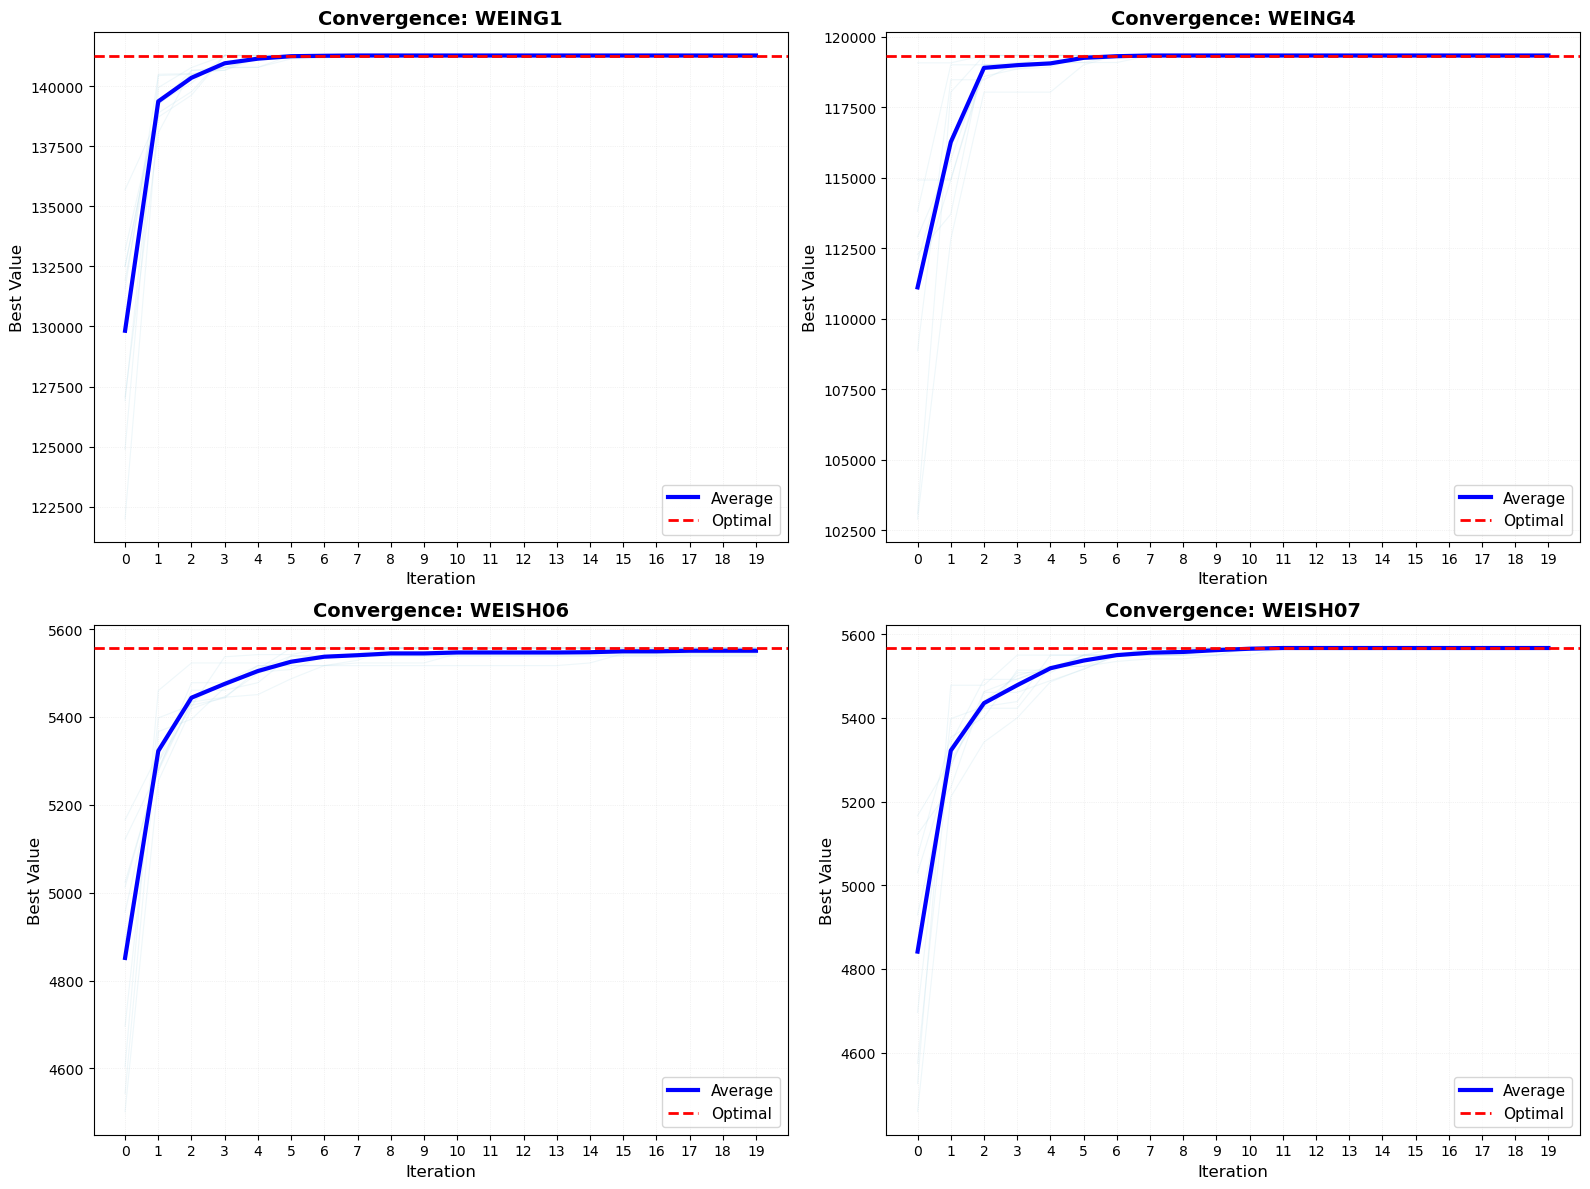


✓ Figure 1: First 4 instances plotted


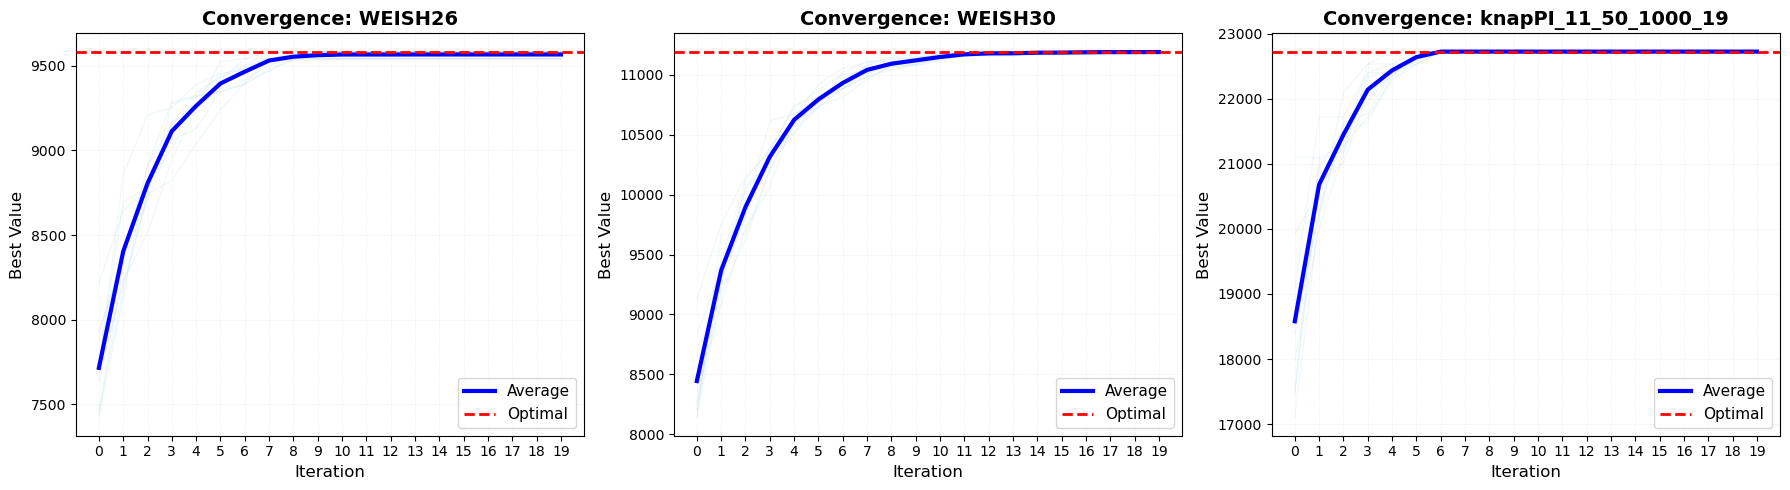

In [33]:
# ============================================================================
# MAIN EXECUTION
# ============================================================================
print("Loading instances...")

loader = DataLoader()

# Load OR-Library instances
or_instances = loader.load_or_library(
    "data/OR-Library/mknap2.txt",
    ['WEING1', 'WEING4', 'WEISH06', 'WEISH07', 'WEISH26', 'WEISH30']
)



# Load one Pisinger instance
pisinger_instance = loader.load_pisinger(
    "data/PisingerHard/knapPI_11_50_1000.csv",
    'knapPI_11_50_1000_19'
)

# Combine all instances
all_instances = or_instances + [pisinger_instance]

print(f"Loaded {len(all_instances)} instances:")
for inst in all_instances:
    print(f"  - {inst.name}: {inst.num_items} items, {inst.num_knapsacks} knapsacks")

# ============================================================================
# CONFIGURE AND RUN EXPERIMENTS
# ============================================================================
ba_params = {
    'num_scout_bees': 150,
    'num_selected_sites': 30,
    'num_elite_sites': 15,
    'num_bees_elite': 80,
    'num_bees_selected': 40,
    'max_iterations': 20,
    'initial_neighborhood_size': 15,
    'shrinking_factor': 0.8,
    'stagnation_limit': 20
}

runner = ExperimentRunner(all_instances)
runner.run_all_instances(num_runs=10, ba_params=ba_params)

# ============================================================================
# 1. RESULTS TABLE
# ============================================================================
summary_df = runner.generate_summary_table()

task_required_columns = [
    'Instance',
    'n',
    'W',
    'Best Value',
    'Weight Used',
    'Baseline',
    'Improvement (%)',
    'Avg Runtime (s)',
    'Avg Iter to Best',
    'Avg Pop Fitness'
]

task_table = summary_df[task_required_columns].copy()

# Format numeric output
task_table['Best Value'] = task_table['Best Value'].astype(int)
task_table['Weight Used'] = task_table['Weight Used'].round(1)
task_table['Baseline'] = task_table['Baseline'].astype(int)
task_table['Improvement (%)'] = task_table['Improvement (%)'].round(2)
task_table['Avg Runtime (s)'] = task_table['Avg Runtime (s)'].round(2)
task_table['Avg Iter to Best'] = task_table['Avg Iter to Best'].round(1)
task_table['Avg Pop Fitness'] = task_table['Avg Pop Fitness'].round(1)

print("\n" + "="*100)
print("RESULTS TABLE")
print("="*100)

styled_table = task_table.style \
    .format({
        'Best Value': '{:,}',
        'Weight Used': '{:.1f}',
        'Baseline': '{:,}',
        'Improvement (%)': '{:.2f}%',
        'Avg Runtime (s)': '{:.2f}',
        'Avg Iter to Best': '{:.1f}',
        'Avg Pop Fitness': '{:,.1f}'
    }) \
    .set_properties(**{
        'text-align': 'right',
        'font-family': 'monospace'
    }) \
    .set_table_styles([
        {'selector': 'th', 'props': [('text-align', 'center'), ('font-weight', 'bold')]},
        {'selector': 'td:first-child', 'props': [('text-align', 'left')]}
    ])

try:
    from IPython.display import display
    display(styled_table)
except:
    print(task_table.to_string(index=False))

print("="*100)

# ============================================================================
# 2. SUMMARY STATISTICS ACROSS 10 RUNS
# ============================================================================
print("\n" + "="*100)
print("STATISTICS OF FINAL BEST VALUES OVER 10 RUNS")
print("="*100)

statistics_columns = [
    'Instance',
    'Best Value',
    'Avg Value',
    'Std Dev',
    'Worst Value'
]

stats_table = summary_df[statistics_columns].copy()
stats_table['Best Value'] = stats_table['Best Value'].astype(int)
stats_table['Avg Value'] = stats_table['Avg Value'].round(1)
stats_table['Std Dev'] = stats_table['Std Dev'].round(2)
stats_table['Worst Value'] = stats_table['Worst Value'].astype(int)

styled_stats = stats_table.style \
    .format({
        'Best Value': '{:,}',
        'Avg Value': '{:,.1f}',
        'Std Dev': '{:.2f}',
        'Worst Value': '{:,}'
    }) \
    .set_properties(**{
        'text-align': 'right',
        'font-family': 'monospace'
    }) \
    .set_table_styles([
        {'selector': 'th', 'props': [('text-align', 'center'), ('font-weight', 'bold')]},
        {'selector': 'td:first-child', 'props': [('text-align', 'left')]}
    ]) \
    .background_gradient(
        subset=['Std Dev'],
        cmap='RdYlGn_r',
        vmin=0,
        vmax=stats_table['Std Dev'].max()
    )

try:
    display(styled_stats)
except:
    print(stats_table.to_string(index=False))

print("="*100)

# ============================================================================
# 3. CONVERGENCE PLOTS
# ============================================================================
print("\n" + "="*100)
print("CONVERGENCE PLOTS: ITERATION vs BEST VALUE")
print("="*100)

# ============================================================================
# FIGURE 1: First 4 instances (2x2 layout)
# ============================================================================
fig1, axes1 = plt.subplots(2, 2, figsize=(16, 12))
axes1 = axes1.flatten()

for idx in range(min(4, len(runner.results))):
    result = runner.results[idx]
    ax = axes1[idx]

    # Individual runs
    for run in result['run_results']:
        ax.plot(run['convergence'], alpha=0.2, color='lightblue', linewidth=0.8)

    # Average convergence
    all_conv = [r['convergence'] for r in result['run_results']]
    max_len = max(len(c) for c in all_conv)
    avg_conv = [np.mean([c[i] for c in all_conv if i < len(c)]) for i in range(max_len)]

    ax.plot(avg_conv, color='blue', linewidth=3, label='Average', zorder=5)

    # Optimal value
    if result['instance'].optimal_value:
        ax.axhline(
            y=result['instance'].optimal_value,
            color='red',
            linestyle='--',
            linewidth=2,
            label='Optimal',
            zorder=10
        )

    ax.set_xlabel('Iteration', fontsize=12)
    ax.set_ylabel('Best Value', fontsize=12)
    ax.set_title(f'Convergence: {result["instance"].name}', fontsize=14, fontweight='bold')
    ax.legend(fontsize=11, loc='lower right')
    ax.grid(True, alpha=0.3, linestyle=':', linewidth=0.5)
    ax.xaxis.set_major_locator(plt.MultipleLocator(1))
    ax.xaxis.set_minor_locator(plt.MultipleLocator(1))

plt.tight_layout()
plt.show()

print("\n✓ Figure 1: First 4 instances plotted")

# ============================================================================
# FIGURE 2: Remaining instances (1x3 layout)
# ============================================================================
if len(runner.results) > 4:
    fig2, axes2 = plt.subplots(1, 3, figsize=(18, 5))

    for idx in range(4, len(runner.results)):
        result = runner.results[idx]
        ax = axes2[idx - 4]

        for run in result['run_results']:
            ax.plot(run['convergence'], alpha=0.2, color='lightblue', linewidth=0.8)

        all_conv = [r['convergence'] for r in result['run_results']]
        max_len = max(len(c) for c in all_conv)
        avg_conv = [np.mean([c[i] for c in all_conv if i < len(c)]) for i in range(max_len)]

        ax.plot(avg_conv, color='blue', linewidth=3, label='Average', zorder=5)

        if result['instance'].optimal_value:
            ax.axhline(
                y=result['instance'].optimal_value,
                color='red',
                linestyle='--',
                linewidth=2,
                label='Optimal',
                zorder=10
            )

        ax.set_xlabel('Iteration', fontsize=12)
        ax.set_ylabel('Best Value', fontsize=12)
        ax.set_title(f'Convergence: {result["instance"].name}', fontsize=14, fontweight='bold')
        ax.legend(fontsize=11, loc='lower right')
        ax.grid(True, alpha=0.3, linestyle=':', linewidth=0.5)
        ax.xaxis.set_major_locator(plt.MultipleLocator(1))
        ax.xaxis.set_minor_locator(plt.MultipleLocator(1))

    plt.tight_layout()
    plt.show()

print("="*100)


## Bees Algorithm Sensitivity Analysis


Running sensitivity analysis on WEISH26...
Instance: 90 items, 5 knapsacks
Optimal value: 9584
Testing num_bees_elite (nre)...
  nre=15: avg=9577.0, std=11.1
  nre=30: avg=9577.0, std=11.1
  nre=45: avg=9569.8, std=17.9
  nre=60: avg=9583.4, std=1.2
  nre=80: avg=9575.6, std=16.8

Testing num_bees_selected (nrb)...
  nrb=10: avg=9584.0, std=0.0
  nrb=20: avg=9584.0, std=0.0
  nrb=30: avg=9575.6, std=16.8
  nrb=40: avg=9575.6, std=16.8
  nrb=50: avg=9584.0, std=0.0

Testing initial_neighborhood_size (ngh)...
  ngh=5: avg=9567.2, std=20.6
  ngh=10: avg=9563.0, std=18.8
  ngh=15: avg=9575.6, std=16.8
  ngh=25: avg=9584.0, std=0.0
  ngh=35: avg=9584.0, std=0.0


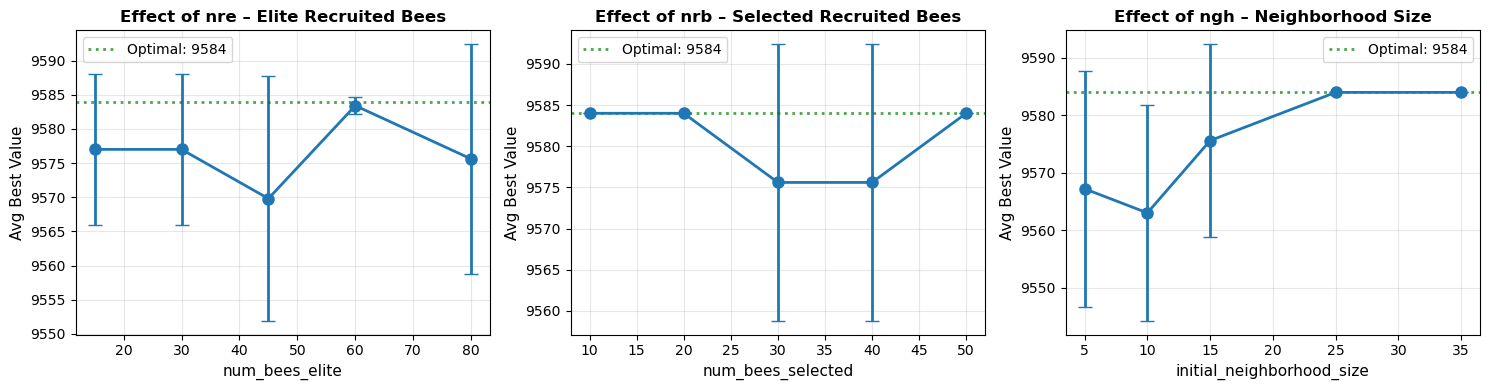

In [34]:
# Sensitivity Analysis
def sensitivity_analysis(instance, n_runs=10):
    """
    Perform sensitivity analysis on key BA parameters:
        - nre: number of elite recruited bees
        - nrb: number of best recruited bees
        - ngh: initial neighborhood size

    Wider parameter ranges are tested. 
    Each configuration is evaluated over multiple runs to compute
    mean performance and standard deviation.

    Args:
        instance (KnapsackInstance): The instance to analyze.
        n_runs (int): Number of repeated runs per parameter setting.

    Returns:
        tuple: (results_dict, base_params)
               results_dict contains x-values, means, and std-devs
               for each tested parameter.
    """

    # Base Bees Algorithm parameters used for all tests
    base_params = {
        'num_scout_bees': 150,
        'num_selected_sites': 30,
        'num_elite_sites': 15,
        'num_bees_elite': 80,
        'num_bees_selected': 40,
        'max_iterations': 20,
        'initial_neighborhood_size': 15,
        'shrinking_factor': 0.8,
        'stagnation_limit': 20
    }

    # Dictionary storing results for each tested parameter
    results = {
        'num_bees_elite': {}, 
        'num_bees_selected': {}, 
        'initial_neighborhood_size': {}
    }

    # -------------------------------------------------------------
    # Test nre = num_bees_elite
    # -------------------------------------------------------------
    print("Testing num_bees_elite (nre)...")
    nre_vals = [15, 30, 45, 60, 80]
    results['num_bees_elite']['x'] = nre_vals
    results['num_bees_elite']['y'] = []
    results['num_bees_elite']['std'] = []

    for nre in nre_vals:
        runs = []
        for seed in range(n_runs):
            ba = BeesAlgorithmStandard(
                instance,
                num_scout_bees=base_params['num_scout_bees'],
                num_selected_sites=base_params['num_selected_sites'],
                num_elite_sites=base_params['num_elite_sites'],
                num_bees_elite=nre,
                num_bees_selected=base_params['num_bees_selected'],
                max_iterations=base_params['max_iterations'],
                initial_neighborhood_size=base_params['initial_neighborhood_size'],
                shrinking_factor=base_params['shrinking_factor'],
                stagnation_limit=base_params['stagnation_limit'],
                random_seed=seed
            )
            _, best_val, _ = ba.optimize()
            runs.append(best_val)

        results['num_bees_elite']['y'].append(np.mean(runs))
        results['num_bees_elite']['std'].append(np.std(runs))

        print(f"  nre={nre}: avg={np.mean(runs):.1f}, std={np.std(runs):.1f}")

    # -------------------------------------------------------------
    # Test nrb = num_bees_selected
    # -------------------------------------------------------------
    print("\nTesting num_bees_selected (nrb)...")
    nrb_vals = [10, 20, 30, 40, 50]
    results['num_bees_selected']['x'] = nrb_vals
    results['num_bees_selected']['y'] = []
    results['num_bees_selected']['std'] = []

    for nrb in nrb_vals:
        runs = []
        for seed in range(n_runs):
            ba = BeesAlgorithmStandard(
                instance,
                num_scout_bees=base_params['num_scout_bees'],
                num_selected_sites=base_params['num_selected_sites'],
                num_elite_sites=base_params['num_elite_sites'],
                num_bees_elite=base_params['num_bees_elite'],
                num_bees_selected=nrb,
                max_iterations=base_params['max_iterations'],
                initial_neighborhood_size=base_params['initial_neighborhood_size'],
                shrinking_factor=base_params['shrinking_factor'],
                stagnation_limit=base_params['stagnation_limit'],
                random_seed=seed
            )
            _, best_val, _ = ba.optimize()
            runs.append(best_val)

        results['num_bees_selected']['y'].append(np.mean(runs))
        results['num_bees_selected']['std'].append(np.std(runs))

        print(f"  nrb={nrb}: avg={np.mean(runs):.1f}, std={np.std(runs):.1f}")

    # -------------------------------------------------------------
    # Test ngh = initial_neighborhood_size
    # -------------------------------------------------------------
    print("\nTesting initial_neighborhood_size (ngh)...")
    ngh_vals = [5, 10, 15, 25, 35]
    results['initial_neighborhood_size']['x'] = ngh_vals
    results['initial_neighborhood_size']['y'] = []
    results['initial_neighborhood_size']['std'] = []

    for ngh in ngh_vals:
        runs = []
        for seed in range(n_runs):
            ba = BeesAlgorithmStandard(
                instance,
                num_scout_bees=base_params['num_scout_bees'],
                num_selected_sites=base_params['num_selected_sites'],
                num_elite_sites=base_params['num_elite_sites'],
                num_bees_elite=base_params['num_bees_elite'],
                num_bees_selected=base_params['num_bees_selected'],
                max_iterations=base_params['max_iterations'],
                initial_neighborhood_size=ngh,
                shrinking_factor=base_params['shrinking_factor'],
                stagnation_limit=base_params['stagnation_limit'],
                random_seed=seed
            )
            _, best_val, _ = ba.optimize()
            runs.append(best_val)

        results['initial_neighborhood_size']['y'].append(np.mean(runs))
        results['initial_neighborhood_size']['std'].append(np.std(runs))

        print(f"  ngh={ngh}: avg={np.mean(runs):.1f}, std={np.std(runs):.1f}")

    return results, base_params


# -------------------------------------------------------------
# Run sensitivity analysis on a representative instance
# -------------------------------------------------------------
# Example: WEISH26 (harder OR-Library MKP instance)
representative_instance = all_instances[4]
print(f"Running sensitivity analysis on {representative_instance.name}...")
print(f"Instance: {representative_instance.num_items} items, "
      f"{representative_instance.num_knapsacks} knapsacks")
print(f"Optimal value: {representative_instance.optimal_value}")

results, base_params = sensitivity_analysis(representative_instance, n_runs=5)

# -------------------------------------------------------------
# Plot results
# -------------------------------------------------------------
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

params_info = [
    ('num_bees_elite', 'nre – Elite Recruited Bees'),
    ('num_bees_selected', 'nrb – Selected Recruited Bees'),
    ('initial_neighborhood_size', 'ngh – Neighborhood Size')
]

for i, (param, title) in enumerate(params_info):
    ax = axes[i]

    ax.errorbar(
        results[param]['x'],
        results[param]['y'],
        yerr=results[param]['std'],
        marker='o',
        capsize=5,
        linewidth=2,
        markersize=8
    )

    # Plot optimal horizontal line if known
    if representative_instance.optimal_value:
        ax.axhline(
            y=representative_instance.optimal_value,
            color='green',
            linestyle=':',
            linewidth=2,
            alpha=0.7,
            label=f'Optimal: {representative_instance.optimal_value}'
        )

    ax.set_xlabel(param, fontsize=11)
    ax.set_ylabel('Avg Best Value', fontsize=11)
    ax.set_title(f'Effect of {title}', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=10)

plt.tight_layout()
plt.show()
